In [1]:
import process as pc
from IPython.core.interactiveshell import InteractiveShell

from sklearn.svm import LinearSVC
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from skimage import img_as_float
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import joblib
import cv2

from sklearn.decomposition import PCA
import numpy as np

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

In [2]:
positive_images_path = pc.DATA_PATH+"/img_align_celeba"
negative_images_path = pc.DATA_PATH+"/caltech-101/101_ObjectCategories"

pc.extract_dataset(positive_images_path)
bad_imgs_path_list = pc.extract_dataset(negative_images_path, folder="multi_folders")

Dataset already extracted


In [3]:
n_good_images = 7700
n_bad_images_folder=250
size_w = size_h = 96

img_list = pc.load_images(positive_images_path, number_of_images=n_good_images, random_seed=7) 
img_tmp = pc.load_image(positive_images_path)
img_tmp = img_as_float(cv2.imread(img_tmp))
images = np.empty((n_good_images, size_w, size_h), dtype=np.uint8)

for i, img in enumerate(img_list):
    images[i, ...] = pc.process_image(pc.DATA_PATH+"/img_align_celeba/"+img, resize=True, img_resize=(size_w, size_h))

Loaded image:  ../data/img_align_celeba/004925.jpg


In [4]:
bad_img_list = []
for fld in bad_imgs_path_list:
    tmp_img_list = pc.load_images(negative_images_path+"/"+fld, number_of_images=n_bad_images_folder, random_seed=7)
    bad_img_list += [negative_images_path+"/"+fld+'/'+img for img in tmp_img_list]


bad_images = np.empty((len(bad_img_list), size_w, size_h), dtype=np.uint8)
for i, img in enumerate(bad_img_list):
    bad_images[i, ...] = pc.process_image(img, resize=True, img_resize=(size_w, size_h))

/home/enrmic/ml_fondamenti_project/face_detection_project_2/src/user_warnings.py:4: UserWarning: The requested number of images is greater than the number of images in the folder
  warnings.warn("The requested number of images is greater than the number of images in the folder", UserWarning)


(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

(-0.5, 95.5, 95.5, -0.5)

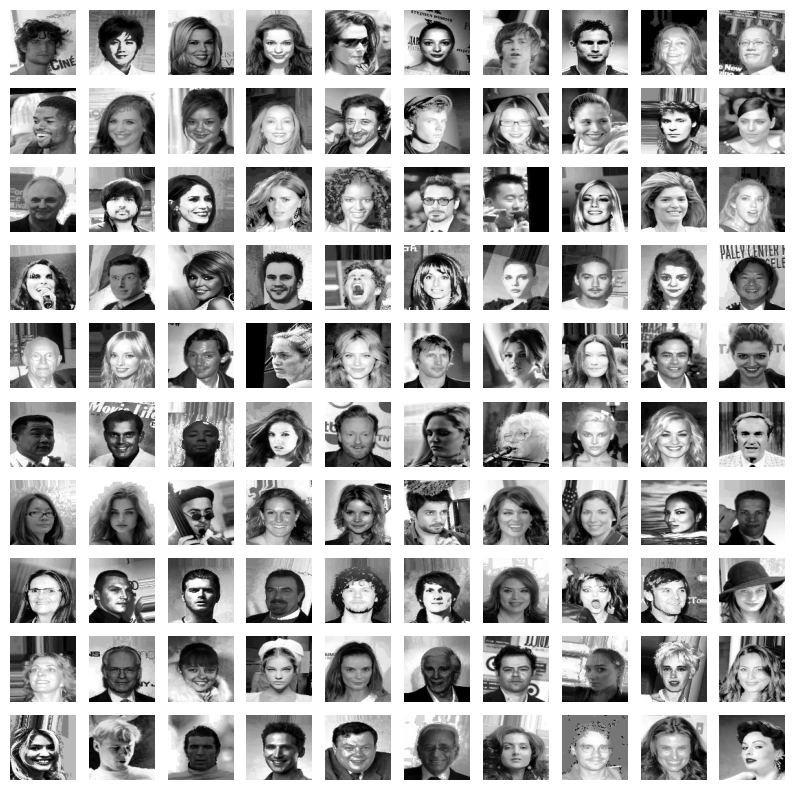

In [5]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(images[i*10+j], cmap='gray')
        ax[i, j].axis('off')

In [6]:
images.shape
bad_images.shape

(7700, 96, 96)

(7459, 96, 96)

In [7]:
dataset = np.concatenate((images, bad_images), axis=0)
dataset.shape

(15159, 96, 96)

In [8]:
good_samples = n_good_images
bad_samples = len(bad_img_list)
ftr_shape = 0
for i, img in enumerate(dataset):
   _, features = pc.extract_ORB_features(img, n_keypoints=32)
   if features is None:
      if i < good_samples:
            good_samples -= 1
      else:
         bad_samples -= 1
      continue
   features = features.flatten()
   if i == 0:
      ftr_shape = features.shape
      X = np.array([features])
   else:
      if features.shape == ftr_shape:
         X = np.append(X, [features], axis=0)
      else:
         if i < good_samples:
            good_samples -= 1
         else:
            bad_samples -= 1


In [9]:
good_samples
bad_samples
y = np.concatenate((np.ones(good_samples), np.zeros(bad_samples))) 
X.shape
y.shape

7700

7452

(15152, 8192)

(15152,)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

In [11]:
X_train.shape
y_train.shape

X_train[0]
y_train[0]


(13636, 8192)

(13636,)

array([ True,  True,  True, ...,  True, False, False])

1.0

PCA(n_components=32, random_state=7, whiten=True)

(0.0, 1.02)

Text(0.5, 0, 'Number of components')

Text(0, 0.5, 'Explained variance')

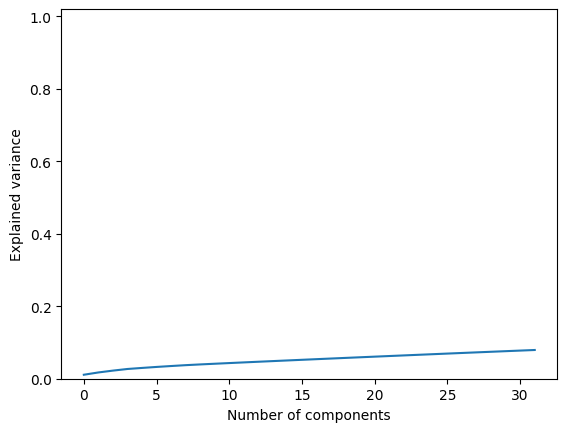

array([0.01098699, 0.01730513, 0.02237452, 0.02686679, 0.02976996,
       0.03252748, 0.03503107, 0.03741626, 0.03945598, 0.04134415,
       0.04320575, 0.04504094, 0.04685346, 0.04865685, 0.05043538,
       0.05220884, 0.05396636, 0.05571895, 0.05746082, 0.05919239,
       0.06090926, 0.06262158, 0.0643237 , 0.06601751, 0.06770767,
       0.06939417, 0.07106701, 0.07273229, 0.07438145, 0.07602068,
       0.07765701, 0.07928666])

In [12]:
pca = PCA(n_components=32, whiten=True, random_state=7)
pca.fit(X_train)
var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(var)
plt.ylim(0, 1.02)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()
var


In [13]:
idx = [i for i in range(len(var)) if var[i] > 0.95]
idx

[]

In [14]:
if 0:
    pca = PCA(n_components=idx[-1], whiten=True, random_state=7)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    X_train_pca.shape
    y_train.shape
    print("PCA done")
else:
    X_train_pca = X_train
    X_test_pca = X_test

In [15]:
param_grid = { 'C' : [np.power(10., i) for i in range(-2, 2)],
               'max_iter' : [7500],
               'random_state' : [7] }

grid_searh = GridSearchCV(LinearSVC(), param_grid, cv=5, n_jobs=2)
grid_searh.fit(X_train_pca, y_train)
grid_searh.best_params_

/home/enrmic/ml_fondamenti_project/face_detection_project_2/prj_env/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/enrmic/ml_fondamenti_project/face_detection_project_2/prj_env/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/enrmic/ml_fondamenti_project/face_detection_project_2/prj_env/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/enrmic/ml_fondamenti_project/face_detection_project_2/prj_env/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWa

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=2,
             param_grid={'C': [0.01, 0.1, 1.0, 10.0], 'max_iter': [7500],
                         'random_state': [7]})

{'C': 0.01, 'max_iter': 7500, 'random_state': 7}

In [16]:
best_svc = grid_searh.best_estimator_

best_svc.score(X_train_pca, y_train)

best_svc.score(X_test_pca, y_test)

0.9998533294221179

0.6978891820580475

In [17]:
y_pred = best_svc.predict(X_train_pca)
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy test:", accuracy)


y_pred = best_svc.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy test:", accuracy)

Accuracy test: 0.9998533294221179
Accuracy test: 0.6978891820580475


In [18]:
pipeline_save_path = pc.DATA_PATH+"/svm_model_3.pkl"

from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ('preprocess', pc.process_image),
        ('extract_features', pc.extract_ORB_features),
        ('pca', pca),
        ('svc', best_svc)  
    ])

joblib.dump(
    pipeline, pipeline_save_path
    )

['../data/svm_model_3.pkl']

In [19]:
pipeline_save_path = pc.DATA_PATH+"/svm_model_3.pkl"
image_path = pc.DATA_PATH+"/final/Valentino_Rossi_2017.jpg"

pipeline = joblib.load(pipeline_save_path)

image = mpimg.imread(image_path)

pc.detect_faces(image_path, pipeline, threshold=0.75, window_size=(128, 128), step_size=(16,16))


[[ True False False ...  True  True False]
 [ True False  True ...  True False  True]
 [ True False  True ...  True  True  True]
 ...
 [False  True False ... False False  True]
 [ True  True  True ... False False  True]
 [False False False ...  True False  True]]


ValueError: X has 256 features, but LinearSVC is expecting 8192 features as input.